In [ ]:
#!git clone https://github.com/whyhardt/SPICE.git

In [ ]:
# !pip install -e SPICE

In [1]:
import matplotlib.pyplot as plt

# For custom RNN
import torch
import torch.nn as nn

## Dataset setup

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [2]:

from spice import SpiceDataset, convert_dataset

# Load your data
dataset = convert_dataset(
    file = '../data/augustat2025/augustat2025.csv',
    df_participant_id='participant_id',
    df_choice='choice',
    df_reward='reward',
    additional_inputs=['shown_at_0', 'shown_at_1'],
    timeshift_additional_inputs=False,
    )

n_actions = dataset.ys.shape[-1]
n_items = dataset.xs[..., 2*n_actions+1].nan_to_num(-1).max().int() + 1
# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = len(dataset.xs[..., -1].unique())

# add shown_at_i_next (alongside shown_at_i) because both are necessary in the SPICE model
shown_at_i_next = dataset.xs[:, 1:, n_actions*2:n_actions*2+2]
xs = torch.concat((dataset.xs[:, :-1, :n_actions*2+2], shown_at_i_next, dataset.xs[:, :-1, -3:]), dim=-1)
ys = dataset.ys[:, :-1]
dataset = SpiceDataset(xs, ys)

# TODO: split into training and test data
dataset_train, dataset_test = dataset, dataset

# instead of timeshift add the predictor states shown_at_0 and shown_at_1 of the next trial to the inputs
# xs = dataset.xs[:, :-1]
# ys = dataset.ys[:, :-1]
# shown_next = dataset.xs[:, 1:, 2*2:-3]
# xs = torch.concat((xs[..., :-3], shown_next, xs[..., -3:]), dim=-1)
# dataset = SpiceDataset(xs, ys)

# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)
print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
print(f"Number of items in dataset: {n_items}")
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([277, 299, 11])
Number of participants: 277
Number of items in dataset: 6
Number of actions in dataset: 2
Number of additional inputs: 4


## SPICE setup

Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

In [3]:
from spice import SpiceConfig

spice_config = SpiceConfig(
    library_setup={
        'value_reward_chosen': ['reward'],
        'value_reward_not_chosen': [],
        'value_reward_not_displayed': [],
        # 'value_choice': ['choice'],
    },
    
    memory_state={
        'value_reward': 0.,
        # 'value_choice': 0.,
        },
)

And now we are going to define the SPICE model which is a child of the `BaseRNN` and `torch.nn.Module` class and takes as required arguments:
1. `spice_config (SpiceConfig)`: previously defined SpiceConfig object
2. `n_actions (int)`: number of possible actions in your dataset (including non-displayed ones if applicable).
3. `n_participants (int)`: number of participants in your dataset.

As usual for a `torch.nn.Module` we have to define at least the `__init__` method and the `forward` method.
The `forward` method gets called when computing a forward pass through the model and takes as inputs `(inputs (SpiceDataset.xs), prev_state (dict, default: None), batch_first (bool, default: False))` and returns `(logits (torch.Tensor, shape: (n_participants*n_blocks*n_experiments, timesteps, n_actions)), updated_state (dict))`. Two necessary method calls inside the forward pass are:
1. `self.init_forward_pass(inputs, prev_state, batch_first) -> SpiceSignals`: returns a `SpiceSignals` object which carries all relevant information already processed.
2. `self.post_forward_pass(SpiceSignals, batch_first) -> SpiceSignals`: does some re-arranging of the logits to adhere to `batch_first`.

In [ ]:
from spice import BaseRNN


class SPICERNN(BaseRNN):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.participant_embedding = self.setup_embedding(num_embeddings=n_participants, embedding_size=self.embedding_size)

        self.setup_module(key_module='value_reward_chosen', input_size=1+self.embedding_size)
        self.setup_module(key_module='value_reward_not_chosen', input_size=self.embedding_size)
        self.setup_module(key_module='value_reward_not_displayed', input_size=self.embedding_size)
        # self.setup_module(key_module='value_choice', input_size=1+self.embedding_size)
        
    def forward(self, inputs, prev_state, batch_first=False):

        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)

        # Get shown items (raw indices) - these are time-shifted, so they refer to the NEXT trial
        shown_at_0_current = spice_signals.additional_inputs[..., 0].long()
        shown_at_1_current = spice_signals.additional_inputs[..., 1].long()
        shown_at_0_next = spice_signals.additional_inputs[..., 2].long()
        shown_at_1_next = spice_signals.additional_inputs[..., 3].long()
        
        participant_embeddings = self.participant_embedding(spice_signals.participant_ids)

        for timestep in spice_signals.timesteps:

            # Transform input data from action space to item space

            # Determine which action was chosen
            action_idx = spice_signals.actions[timestep].argmax(dim=-1)

            # Map to item indices using current trial's shown items
            item_chosen_idx = torch.where(action_idx == 0, shown_at_0_current[timestep], shown_at_1_current[timestep])
            item_not_chosen_idx = torch.where(action_idx == 1, shown_at_0_current[timestep], shown_at_1_current[timestep])

            # Create one-hot masks
            item_chosen_onehot = torch.nn.functional.one_hot(item_chosen_idx, num_classes=self.n_items).float()
            item_not_chosen_onehot = torch.nn.functional.one_hot(item_not_chosen_idx, num_classes=self.n_items).float()
            item_not_displayed_onehot = 1 - (item_chosen_onehot + item_not_chosen_onehot)

            # Map rewards from action space to item space
            reward_action = spice_signals.rewards[timestep, :]  # shape: (batch, n_actions)

            # Create reward tensor in item space (batch, n_items)
            reward_item = torch.zeros(reward_action.shape[0], self.n_items, device=reward_action.device)
            
            # Scatter rewards to the corresponding items:
            # Item at shown_at_0_current gets reward for action 0
            # Item at shown_at_1_current gets reward for action 1
            reward_item.scatter_(1, shown_at_0_current[timestep].unsqueeze(-1), reward_action[:, 0].unsqueeze(-1))
            reward_item.scatter_(1, shown_at_1_current[timestep].unsqueeze(-1), reward_action[:, 1].unsqueeze(-1))
            
            # Update chosen
            self.call_module(
                key_module='value_reward_chosen',
                key_state='value_reward',
                action_mask=item_chosen_onehot,
                inputs=(
                    reward_item,
                    # ...
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )

            # Update not chosen
            self.call_module(
                key_module='value_reward_not_chosen',
                key_state='value_reward',
                action_mask=item_not_chosen_onehot,
                inputs=None,
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )

            # Update not displayed
            self.call_module(
                key_module='value_reward_not_displayed',
                key_state='value_reward',
                action_mask=item_not_displayed_onehot,
                inputs=None,
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )

            # Transform values from item space to action space for NEXT trial (for prediction)
            # Use the time-shifted items (next trial's items)
            value_at_0 = torch.gather(self.state['value_reward'], 1, shown_at_0_next[timestep].unsqueeze(-1))
            value_at_1 = torch.gather(self.state['value_reward'], 1, shown_at_1_next[timestep].unsqueeze(-1))

            # log action values
            spice_signals.logits[timestep] = torch.concat([value_at_0, value_at_1], dim=-1)

        spice_signals = self.post_forward_pass(spice_signals, batch_first)

        return spice_signals.logits, self.get_state()

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [5]:
from spice import SpiceEstimator

path_spice = '../params/augustat2025/spice_augustat2025.pkl'

estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=SPICERNN,
        spice_config=spice_config,
        n_actions=n_actions,
        n_items=n_items,
        n_participants=n_participants,
        
        # rnn training parameters
        epochs=1000,
        warmup_steps=250,
        learning_rate=0.01,
        
        # sindy fitting parameters
        sindy_weight=0.1,
        sindy_threshold=0.05,
        sindy_threshold_frequency=1,
        sindy_threshold_terms=1,
        sindy_cutoff_patience=100,
        sindy_epochs=1000,
        sindy_alpha=0.0001,
        sindy_library_polynomial_degree=2,
        sindy_ensemble_size=1,
        
        # additional generalization parameters
        bagging=True,
        scheduler=True,
        
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        verbose=True,
        save_path_spice=path_spice,
    )

In [26]:
print(f"\nStarting training on {estimator.device}...")
print("=" * 80)
estimator.fit(dataset_train.xs, dataset_train.ys, dataset_test.xs, dataset_test.ys)
# estimator.load_spice(args.model)
print("=" * 80)
print("\nTraining complete!")

# Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training on cuda...

Training the RNN...
Epoch 1/1000 --- L(Train): 0.7024866 --- L(Val, RNN): 0.6814768 --- L(Val, SINDy): 0.7145708 --- Time: 1.76s; --- Convergence: 6.59e-01; LR: 1.00e-02; Metric: inf; Bad epochs: 0/100
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 12):
value_reward_chosen[t+1] = 0.01 1 + 0.989 value_reward_chosen[t] + 0.011 reward + 0.01 value_reward_chosen^2 + -0.009 value_reward_chosen*reward + 0.01 reward^2 
value_reward_not_chosen[t+1] = -0.008 1 + 0.99 value_reward_not_chosen[t] + -0.01 value_reward_not_chosen^2 
value_reward_not_displayed[t+1] = 0.01 1 + 0.99 value_reward_not_displayed[t] + 0.011 value_reward_not_displayed^2 
--------------------------------------------------------------------------------
Cutoff patience:
value_reward_chosen: 0, 0, 0, 0, 0, 0
value_reward_not_chosen: 0, 0, 0
value_reward_not_displayed: 0, 0, 0
Epoch 2/1000 --- L(Train): 0.6851085 --- L(Val, RNN): 0.665644

In [6]:
# loading a trained spice model; only necessary if not trained in current notebook session
estimator.load_spice(path_spice)

## GRU for benchmarking

Let's code up a general RNN

In [ ]:
import sys

sys.path.append('../..')
from weinhardt2025.benchmarking.benchmarking_gru import training, setup_agent_gru

path_gru = '../../weinhardt2025/params/augustat2025/gru_augustat2025.pkl'

In [8]:
# GRU specifications:
# 1. In order to function seamlessly with the rest of the framework the GRU has to output (logits, hidden_state)
# 2. Because of the task type (more items to remember than displayed for action; n_items > n_actions):
#   2.1 The GRU computes the action values for all items at each timestep (chosen, not chosen but displayed, and not displayed)
#   2.2 To facilitate selection only among the shown options, the GRU has to map the values from the item space (all values) to the action space (only displayed ones)

class GRU(torch.nn.Module):
    
    def __init__(self, n_actions, n_items, additional_inputs: int = 0, hidden_size: int = 32, **kwargs):
        super().__init__()
        
        self.gru_features = hidden_size
        self.n_items = n_items
        self.n_actions = n_actions
        self.additional_inputs = additional_inputs

        self.linear_in = torch.nn.Linear(in_features=n_actions+1+additional_inputs, out_features=hidden_size)
        self.dropout = torch.nn.Dropout(0.1)
        self.gru = torch.nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.linear_out = torch.nn.Linear(in_features=hidden_size, out_features=n_items)
        
    def forward(self, inputs, state=None):
        
        actions = inputs[..., :self.n_actions]
        rewards = inputs[..., self.n_actions:2*self.n_actions].nan_to_num(0).sum(dim=-1, keepdims=True)
        item_pairs = inputs[..., self.n_actions*2+2:self.n_actions*2+2+self.additional_inputs]  # +2 -> skip shown_at_i; keep only shown_at_i_next
        inputs = torch.concat((actions, rewards, item_pairs), dim=-1)
        
        # Get item pairs
        # item_pairs = inputs[..., 3*self.n_actions:3*self.n_actions+2]
        
        if state is not None and len(inputs.shape) == 3:
            state = state.reshape(1, 1, self.gru_features)
        
        y = self.linear_in(inputs.nan_to_num(0))
        y = self.dropout(y)
        y, state = self.gru(y, state)
        y = self.dropout(y)
        y = self.linear_out(y)
        
        # map values from item space into action space to determine the next action based on the shown options
        item1_values = torch.gather(y, 2, item_pairs[..., 0].unsqueeze(-1).nan_to_num(0).long())
        item2_values = torch.gather(y, 2, item_pairs[..., 1].unsqueeze(-1).nan_to_num(0).long())
        y = torch.cat([item1_values, item2_values], dim=-1)
        
        return y, state

In [9]:
epochs = 1000

gru = GRU(n_actions=n_actions, n_items=n_items, additional_inputs=2).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

In [22]:
gru = training(
    gru=gru,
    optimizer=optimizer,
    dataset_train=dataset_train,
    dataset_test=dataset_test,
    epochs=epochs,
    )

torch.save(gru.state_dict(), path_gru)
print("Trained GRU parameters saved to " + path_gru)


Epoch 1/1000: L(Train): 0.7699153423309326; L(Test): 0.5198200345039368
Epoch 2/1000: L(Train): 0.5324288606643677; L(Test): 0.4583016335964203
Epoch 3/1000: L(Train): 0.4571947753429413; L(Test): 0.45632404088974
Epoch 4/1000: L(Train): 0.47100141644477844; L(Test): 0.46150436997413635
Epoch 5/1000: L(Train): 0.46861299872398376; L(Test): 0.4664887487888336
Epoch 6/1000: L(Train): 0.45548897981643677; L(Test): 0.4665026366710663
Epoch 7/1000: L(Train): 0.4839845597743988; L(Test): 0.4592019021511078
Epoch 8/1000: L(Train): 0.458694726228714; L(Test): 0.4502069056034088
Epoch 9/1000: L(Train): 0.44866496324539185; L(Test): 0.4445895850658417
Epoch 10/1000: L(Train): 0.4370618164539337; L(Test): 0.44436201453208923
Epoch 11/1000: L(Train): 0.4357244074344635; L(Test): 0.44738277792930603
Epoch 12/1000: L(Train): 0.42047029733657837; L(Test): 0.4485151767730713
Epoch 13/1000: L(Train): 0.4540117084980011; L(Test): 0.44732972979545593
Epoch 14/1000: L(Train): 0.4637111723423004; L(Test): 

In [10]:
gru_agent = setup_agent_gru(path_gru, gru)

## Plot SPICE against benchmark models

In [ ]:
print("SPICE model for participant 0")
estimator.print_spice_model(3)
print("\nSPICE model for participant 1")
estimator.print_spice_model(4)
print("\nSPICE model for participant 2")
estimator.print_spice_model(5)

SPICE model for participant 0
value_reward_chosen[t+1] = 0.165 1 + 0.854 value_reward_chosen[t] + 0.927 reward + -0.427 value_reward_chosen*reward 
value_reward_not_chosen[t+1] = -0.779 1 + 0.041 value_reward_not_chosen[t] 
value_reward_not_displayed[t+1] = 1.0 value_reward_not_displayed[t] 

SPICE model for participant 1
value_reward_chosen[t+1] = 1.0 value_reward_chosen[t] + 0.931 reward + -0.491 value_reward_chosen*reward 
value_reward_not_chosen[t+1] = -0.801 1 + 0.011 value_reward_not_chosen[t] 
value_reward_not_displayed[t+1] = 1.0 value_reward_not_displayed[t] 

SPICE model for participant 2
value_reward_chosen[t+1] = -0.146 1 + 0.841 value_reward_chosen[t] + 1.056 reward + -0.489 value_reward_chosen*reward 
value_reward_not_chosen[t+1] = -0.741 1 + 0.045 value_reward_not_chosen[t] 
value_reward_not_displayed[t+1] = 1.0 value_reward_not_displayed[t] 


value_reward_chosen[t+1] = 0.9 value_reward_chosen[t] + 0.921 reward + -0.384 value_reward_chosen*reward 
value_reward_not_chosen[t+1] = -0.791 1 + 0.027 value_reward_not_chosen[t] 
value_reward_not_displayed[t+1] = 1.0 value_reward_not_displayed[t] 


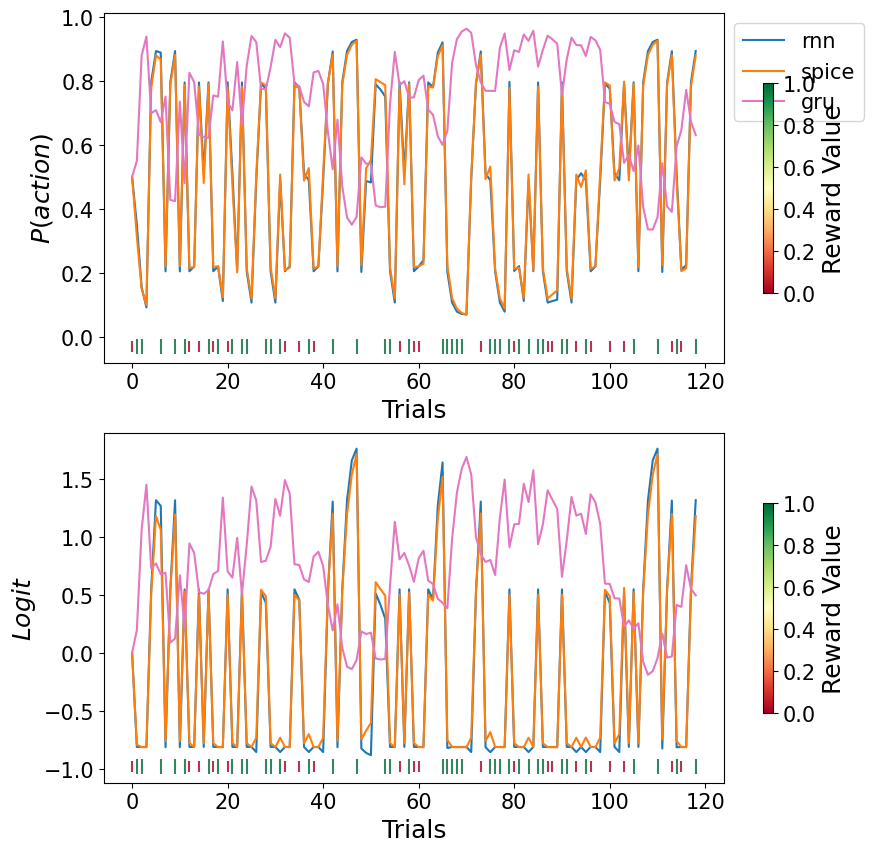

In [37]:
from spice import plot_session

# plotting
participant_id = 0

estimator.print_spice_model(participant_id)

agents = {
    # add baseline agent here
    'rnn': estimator.rnn_agent,
    'spice': estimator.spice_agent,
    # 'baseline': baseline_agent,
    'gru': gru_agent,
}

fig, axs = plot_session(agents, dataset.xs[participant_id])
plt.show()